# Classification multiclasses des images du dataset 5 flowers

# Data Augmentation + Transfer Learning avec MobileNetV3Small + Fine Tuning

- Auteur : Laurent PISSOT
- Date : 12 Mai 2025
- Statut : **Validé**
- Références : <br>https://docs.pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_small.html, <br> https://pytorch.org/blog/torchvision-mobilenet-v3-implementation/..., <br> https://docs.pytorch.org/vision/0.22/models.html, <br> https://pypi.org/project/torch/2.6.0/, <br> requêtes Copilot !

In [21]:
!python --version

Python 3.12.3


### Introduction

MobileNetV3, une architecture de pointe pour des modèles de deep learning efficaces conçus pour les appareils mobiles. Il s’agit de la troisième génération de la famille MobileNet.

Les MobileNet sont des réseaux neuronaux convolutifs (CNN) légers optimisés pour la vitesse et la précision. MobileNetV3 introduit de nouvelles améliorations de l’architecture, telles que la recherche d’architecture neuronale (NAS) sensible à la plate-forme et NetAdapt, afin d’améliorer encore les performances.

**Qu'est-ce que MobileNet ?**<br>
MobileNet est une famille de réseaux neuronaux conçus pour une inférence efficace sur les appareils mobiles et intégrés. Le MobileNetV1 original a introduit une technique appelée convolutions séparables en profondeur, qui a considérablement réduit le nombre de calculs par rapport aux convolutions traditionnelles.

Les MobileNet sont particulièrement bien adaptés aux tâches telles que la classification d’images, la détection d’objets et la segmentation sémantique sur des appareils disposant d’une puissance de calcul limitée.

**MobileNetV1 vs V2 vs V3 : quelle est la différence ?**

**MobileNetV1** : Introduction de convolutions séparables en profondeur pour réduire le calcul et la taille du modèle.

**MobileNetV2** : Ajout de résidus inversés et de goulets d’étranglement linéaires pour rendre le réseau plus efficace.

**MobileNetV3** : Combine le meilleur des deux versions précédentes et les améliore avec :

- NAS sensible à la plate-forme pour optimiser l’architecture des processeurs mobiles.
- NetAdapt pour affiner les couches réseau pour plus d’efficacité.
- Modules Squeeze-and-Excite (SE) pour stimuler l’apprentissage des fonctionnalités.
- Fonction d’activation H-Swish pour améliorer l’efficacité du modèle.

## Étape 1 : Configuration de l'environnement d'exécution

In [22]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights, mobilenet_v3_small, MobileNet_V3_Small_Weights
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pathlib

# Définition des constantes
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 0.001
NB_EPOCHS = 10
NB_CLASSES = 5

In [23]:
torch.__version__

'2.7.1+cu126'

#### Définition des fonctions locales

In [24]:
# Our function needs a different name to sklearn's plot_confusion_matrix
def f_make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

      If classes is passed, confusion matrix will be labelled, if not, integer class values
      will be used.

      Args:
        y_true: Array of truth labels (must be same shape as y_pred).
        y_pred: Array of predicted labels (must be same shape as y_true).
        classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
        figsize: Size of output figure (default=(10, 10)).
        text_size: Size of output figure text (default=15).
        norm: normalize values or not (default=False).
        savefig: save confusion matrix to file (default=False).
  
      Returns:
        A labelled confusion matrix plot comparing y_true and y_pred.

      Example usage:
        make_confusion_matrix(y_true=test_labels, # ground truth test labels
                              y_pred=y_preds, # predicted labels
                              classes=class_names, # array of class label names
                              figsize=(15, 15),
                              text_size=10)
    """
    import itertools
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import confusion_matrix
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)
  
    # Are there a list of classes?
    if classes:  labels = classes
    else:  labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes), # create enough axis slots for each class
           yticks=np.arange(n_classes), 
           xticklabels=labels, # axes will labeled with class names (if they exist) or ints
           yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
           plt.text(j, i, f"{cm[i, j]}",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)
    plt.show()

In [25]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure 3 channels (RGB)
    return transform(image).unsqueeze(0)  # Add batch dimension

## Étape 2 : Chargement du modèle pré entrainé MobileNetV3

In [26]:
# Load MobileNetV3-Large pretrained on ImageNet
# Pre-trained Model: The pretrained=True argument loads a model trained on ImageNet.
#mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)  # Use mobilenet_v3_small for the smaller version
mobilenet_v3 = models.mobilenet_v3_small(pretrained=True, weights=models.MobileNet_V3_Small_Weights.DEFAULT)

# Modify the final layer for a custom number of classes (e.g., 10)
mobilenet_v3.classifier[3] = nn.Linear(mobilenet_v3.classifier[3].in_features, NB_CLASSES)   # mobilenet_v3_small

# Verify the modified model
print(mobilenet_v3)

#train on GPU if CUDA is available, else on CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mobilenet_v3 = mobilenet_v3.to(device)

#print training information
print("")
if torch.cuda.is_available():  hardware = "GPU " + str(device) 
else:    hardware = "CPU (CUDA was not found)" 
print("Training information:")
print("iterations:", NB_EPOCHS)
print("batch size:", BATCH_SIZE)
print("")

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Étape 3 : Réglage de précision du modèle MobileNetV3 sur les couches de classification

* Prétraitement et enrichissement des données (Data Augmentation) :

In [27]:
DIR_IMG_TRAIN = 'flower_photos'  # localisation a adapter
DIR_IMG_TEST = 'flower_photos_test'  # localisation a adapter

In [28]:
# Pour l'entraînement (avec augmentation)
# 1. Image Preprocessing: The input image must be resized, normalized, and converted to a tensor.
NORM_MEANS = (0.485, 0.456, 0.406) #precomputed channel means of ImageNet(train) for normalization
NORM_STDS = (0.229, 0.224, 0.225) #precomputed standard deviations

train_transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),  # Resize image to 224x224
                                      #transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),   
                                      transforms.RandomRotation(degrees=15),   
                                      transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=NORM_MEANS, std=NORM_STDS)])

# Load dataset et configure DataLoaders
image_train_path = DIR_IMG_TRAIN
train_dataset = datasets.ImageFolder(root=image_train_path, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [29]:
# Constantes pour l'apprentissage
LR = 0.001
NB_EPOCHS = 10

In [30]:
# Definition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v3.parameters(), lr=LR)

# Itération d'entrainement du modèle
num_epochs = NB_EPOCHS
mobilenet_v3.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct, total = 0, 0
    for inputs, labels in train_loader:
        #optimizer.zero_grad()
        
        # Forward pass
        outputs = mobilenet_v3(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        #loss.backward(); optimizer.step()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    print(f"Epoch {epoch+1} : Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch 1 : Loss: 0.3868, Accuracy: 85.78%
Epoch 2 : Loss: 0.1775, Accuracy: 93.99%
Epoch 3 : Loss: 0.1468, Accuracy: 94.82%
Epoch 4 : Loss: 0.1229, Accuracy: 95.92%
Epoch 5 : Loss: 0.1119, Accuracy: 96.18%
Epoch 6 : Loss: 0.1174, Accuracy: 96.14%
Epoch 7 : Loss: 0.0925, Accuracy: 96.49%
Epoch 8 : Loss: 0.1131, Accuracy: 97.10%
Epoch 9 : Loss: 0.1405, Accuracy: 95.65%
Epoch 10 : Loss: 0.1280, Accuracy: 95.74%


In [31]:
# Liste de tous les labels
DIR_TEST_IMG = pathlib.Path(DIR_IMG_TEST)
LST_TEST_PATHS = list(DIR_TEST_IMG.glob('*/*'))
LST_TEST_PATHS = [str(x) for x in LST_TEST_PATHS]

LST_CLS_NAMES = sorted(item.name for item in DIR_TEST_IMG.glob('*/') if item.is_dir())
NUM_CAT = len(LST_CLS_NAMES)  # le nombre de classes
# Assignation d'un index à chaque label dans un dictionnaire 
LBL_TO_IDX = dict((name, index) for index, name in enumerate(LST_CLS_NAMES))
IDX_TO_LBL = {v: k for k, v in train_dataset.class_to_idx.items()}

print("Label to Index : ", LBL_TO_IDX, "\nIndex to Label : ", IDX_TO_LBL)

Label to Index :  {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4} 
Index to Label :  {0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}


* Fine Tuning : pas vraiment utile ici ?

On gèle les couches d'extraction des features (toutes), reste une seule couche de classification

In [32]:
# 1. Define data transformations

# TEST dataset s'appuyant sur le dossier distinct ./flower_photos_test réparti en classes sous forme de sous-dossiers
transform_test = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),  # Resize image to 224x224
                                     transforms.ToTensor(),                   # Convert image to tensor
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])
image_test_path = DIR_IMG_TEST
test_dataset = datasets.ImageFolder(root=image_test_path, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
# Vérifications
# test_dataset.classes  # ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
# test_dataset.class_to_idx  # {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

### Étape 4 : Évaluation du modèle :

* Mesure des performances en TRAIN en itérant sur les données du dataset `train_loader` :

In [34]:
# Evaluation Mode: Always set the model to evaluation mode using model.eval() to disable dropout and batch normalization updates.
mobilenet_v3.eval()  # Set the model to evaluation mode

correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = mobilenet_v3(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Train Accuracy: {accuracy:.2f}%')

Train Accuracy: 94.21%


* Mesure des performances en TEST en itérant sur les données du dataset `test_loader` :

In [35]:
# Predict (Make Predictions on New Data)
#mobilenet_v3.eval()  # Set to evaluation mode

correct, total = 0, 0
with torch.no_grad():  # Disable gradient tracking for efficiency
    for inputs, labels in test_loader:  # Assuming `test_loader` is your DataLoader
        predictions = mobilenet_v3(inputs)  # Forward pass
        predicted = torch.argmax(predictions, dim=1)  # Get class labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 88.25%


### Etape 5 : Inférences unitaires et globales à l'ensemble de test

In [36]:
# Inference unitaire
from PIL import Image
import torch.nn.functional as F

image_path = DIR_IMG_TEST + '/daisy/Image_8.jpg'
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)), transforms.ToTensor(), ])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Pass tensor to the model for inference
results = mobilenet_v3(image_tensor)
print("Résultats de la prédiction :", results)

predicted_class = results.argmax().item()
print("Classe prédite :", predicted_class)
score = results[predicted_class]
print("Score de confiance associé :", score.max().detach().numpy())
probs = F.softmax(results, dim=1) # Appliquer softmax
print("Probabilités Softmax estimées :", probs)
confidence, predicted_class = torch.max(probs, dim=1)
# Affichage du score de confiance en pourcentage
print(f"Classe prédite : {IDX_TO_LBL[predicted_class.item()]}, Probabilité Softmax estimée : {confidence.item() * 100:.2f}%")

Résultats de la prédiction : tensor([[ 5.3134,  4.4745, -4.3276, -4.0578, -2.7292]],
       grad_fn=<AddmmBackward0>)
Classe prédite : 0
Score de confiance associé : 5.313372
Probabilités Softmax estimées : tensor([[6.9800e-01, 3.0167e-01, 4.5377e-05, 5.9429e-05, 2.2439e-04]],
       grad_fn=<SoftmaxBackward0>)
Classe prédite : daisy, Probabilité Softmax estimée : 69.80%


* Nouvelle évaluation globale sur les données de TEST en itérant manuellement sur les images physiques :

In [38]:
# 3. Load and preprocess test data
# Example: Replace with your test dataset
test_images = LST_TEST_PATHS  # List of test image paths
import os

true_labels = [os.path.basename(os.path.dirname(p)) for p in LST_TEST_PATHS]

# 4. Predict and score
predictions, labels = [], []
k = 0
with torch.no_grad():  # Disable gradient computation for inference
    for img_path in test_images:
        #print("Image n°",k)
        #input_tensor = preprocess_image(img_path)
        #output = mobilenet_v3(input_tensor)  # Forward pass

        image = Image.open(img_path).convert('RGB')
        transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        output = mobilenet_v3(image_tensor)  # Forward pass
        predicted_class = output.argmax(dim=1).item()  # Get the predicted class index
        predictions.append(predicted_class)
        labels.append(LBL_TO_IDX[true_labels[k]])
        k += 1
# 5. Calculate accuracy (or other metrics)
accuracy = accuracy_score(labels, predictions)
print(f"Accuracy: {accuracy * 100:.5f}%")

Accuracy: 88.25301%


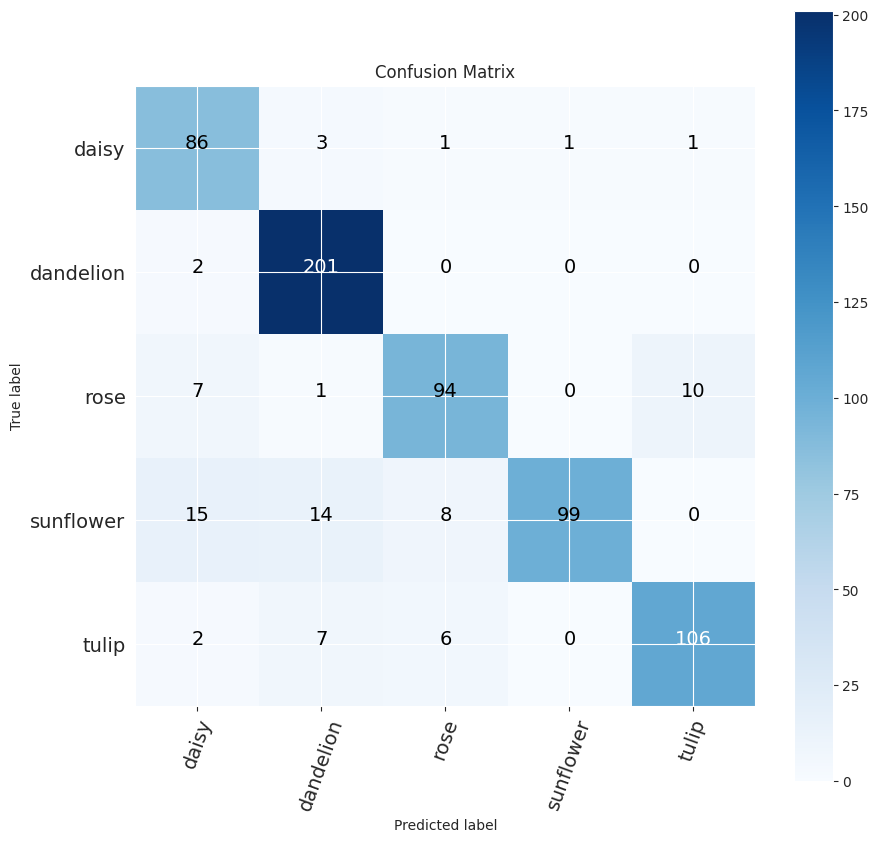

In [39]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
f_make_confusion_matrix(y_true=labels,
                        y_pred=predictions,
                        classes=LST_CLS_NAMES,
                        figsize=(10, 10), text_size=14, norm=False, savefig=False)

### Version spécialisée avec surcharge des couches de classification

In [40]:
import torch
import torch.nn as nn
from torchvision import models

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

class CustomMobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(CustomMobileNetV3, self).__init__()
        
        # Load pre-trained MobileNetV3 (small or large)
        base_model = models.mobilenet_v3_small(pretrained=True, weights=models.MobileNet_V3_Small_Weights.DEFAULT)
        
        # Remove the classifier
        self.features = base_model.features
        
        # Freeze base model layers if needed
        for param in self.features.parameters():  param.requires_grad = False
        
        # Custom classifier
        self.classifier = nn.Sequential(
            nn.Conv2d(576, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Example usage
num_classes = 5  # Change this to match your dataset
model_bis = CustomMobileNetV3(num_classes=num_classes)

# Print model summary (optional)
print(model_bis)

model_bis = model_bis.to(device)

early_stopper = EarlyStopping(patience=3, min_delta=0.001)

CustomMobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1

* Préparation des données :

In [41]:
# Image Preprocessing: The input image must be resized, normalized, and converted to a tensor.
NORM_MEANS = (0.485, 0.456, 0.406) #precomputed channel means of ImageNet(train) for normalization
NORM_STDS = (0.229, 0.224, 0.225) #precomputed standard deviations

train_transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),  # Resize image to 224x224
                                      #transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(15),
                                      transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=NORM_MEANS, std=NORM_STDS)])
val_transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),  # Resize image to 224x224
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=NORM_MEANS, std=NORM_STDS)])

# Load dataset et configure DataLoaders
image_train_path = DIR_IMG_TRAIN
train_dataset = datasets.ImageFolder(root=image_train_path, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = datasets.ImageFolder(root=image_train_path, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

* Entrainement du modèle en itérant sur les datasets TRAIN/VALIDATION :

In [42]:
learning_rate = LR
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bis.parameters(), lr=learning_rate)

# Training loop
for epoch in range(NB_EPOCHS):
    model_bis.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_bis(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(all_labels, all_preds)
    avg_train_loss = running_loss / len(train_loader)
    #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Validation
    model_bis.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_bis(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # After validation loss is computed
    early_stopper(val_loss)

    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break



Epoch [1/10]
Train Loss: 0.4560, Train Acc: 0.8604
Val Loss: 0.1683, Val Acc: 0.9460

Epoch [2/10]
Train Loss: 0.2798, Train Acc: 0.9078
Val Loss: 0.1398, Val Acc: 0.9513

Epoch [3/10]
Train Loss: 0.2436, Train Acc: 0.9179
Val Loss: 0.0957, Val Acc: 0.9666

Epoch [4/10]
Train Loss: 0.1974, Train Acc: 0.9302
Val Loss: 0.0810, Val Acc: 0.9710

Epoch [5/10]
Train Loss: 0.1693, Train Acc: 0.9447
Val Loss: 0.0955, Val Acc: 0.9640

Epoch [6/10]
Train Loss: 0.1654, Train Acc: 0.9381
Val Loss: 0.0641, Val Acc: 0.9785

Epoch [7/10]
Train Loss: 0.1360, Train Acc: 0.9539
Val Loss: 0.0455, Val Acc: 0.9846

Epoch [8/10]
Train Loss: 0.1375, Train Acc: 0.9543
Val Loss: 0.0499, Val Acc: 0.9873

Epoch [9/10]
Train Loss: 0.1320, Train Acc: 0.9570
Val Loss: 0.0386, Val Acc: 0.9890

Epoch [10/10]
Train Loss: 0.1218, Train Acc: 0.9596
Val Loss: 0.0405, Val Acc: 0.9881


* Mesure des performances en TEST en itérant sur les données du dataset `test_loader` :

In [43]:
# Predict (Make Predictions on New Data)
correct, total = 0, 0
with torch.no_grad():  # Disable gradient tracking for efficiency
    for inputs, labels in test_loader:  # Assuming `test_loader` is your DataLoader
        predictions = model_bis(inputs)  # Forward pass
        predicted = torch.argmax(predictions, dim=1)  # Get class labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 91.72%


* Mesure des performances en TEST en itérant sur les images physiques de la liste des sous-dossiers `test_images` :

In [44]:
# 4. Predict and score
predictions, labels = [], []
k = 0
with torch.no_grad():  # Disable gradient computation for inference
    for img_path in test_images:
        #print("Image n°",k)
        #input_tensor = preprocess_image(img_path)
        #output = mobilenet_v3(input_tensor)  # Forward pass
        
        image = Image.open(img_path).convert('RGB')
        transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)), 
                                        transforms.ToTensor(), 
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        output = model_bis(image_tensor)  # Forward pass
        predicted_class = output.argmax(dim=1).item()  # Get the predicted class index
        predictions.append(predicted_class)
        labels.append(LBL_TO_IDX[true_labels[k]])
        k += 1
# 5. Calculate accuracy (or other metrics)
accuracy = accuracy_score(labels, predictions)
print(f"TEST Accuracy: {accuracy * 100:.5f}%")

TEST Accuracy: 91.71687%


* Matrice de confusion et rapport de classification :

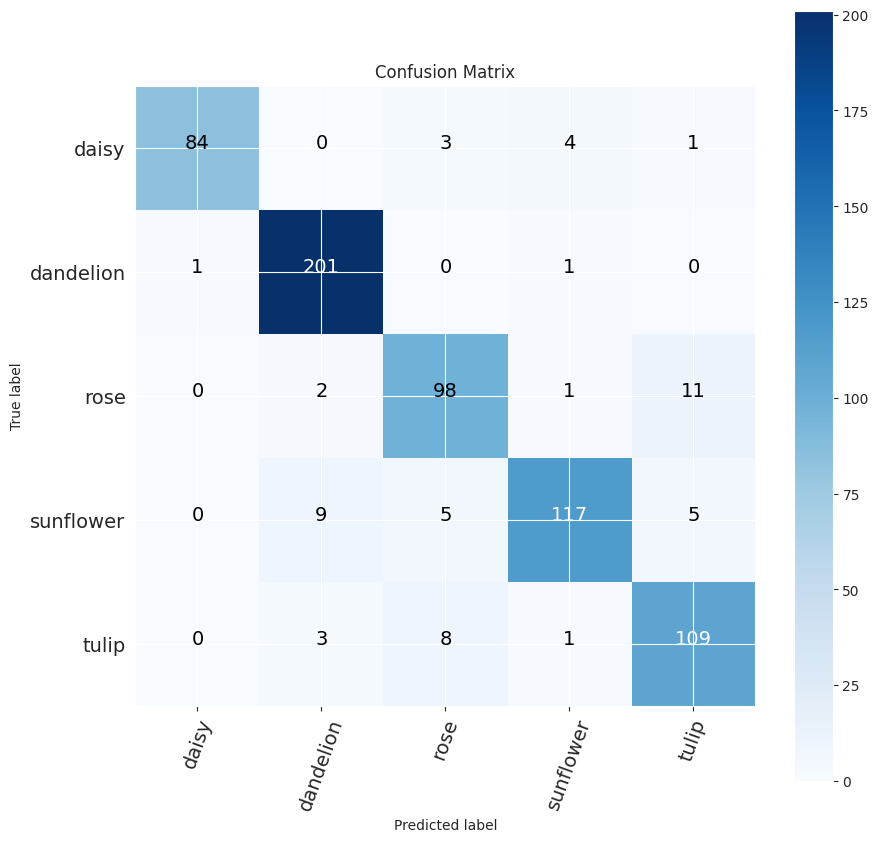

In [45]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
f_make_confusion_matrix(y_true=labels,
                        y_pred=predictions,
                        classes=LST_CLS_NAMES,
                        figsize=(10, 10), text_size=14, norm=False, savefig=False)

In [46]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95        92
           1       0.93      0.99      0.96       203
           2       0.86      0.88      0.87       112
           3       0.94      0.86      0.90       136
           4       0.87      0.90      0.88       121

    accuracy                           0.92       664
   macro avg       0.92      0.91      0.91       664
weighted avg       0.92      0.92      0.92       664

